In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

file_vwnd = './vwnd.mon.mean.nc'
file_uwnd = './uwnd.mon.mean.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)

vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']

In [7]:
vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
vlevel_200 = vwnd[:1,9:10].data[0][:,:][0]

ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]
ulevel_200 = uwnd[:1,9:10].data[0][:,:][0]

# vlevel_sqrt = np.zeros(vlevel_850.shape, dtype=float, order='C') 

def diff_square(a, b):
    # 求两相同大小的矩阵个元素之间的平方和
    _square = np.zeros(vlevel_850.shape, dtype=float, order='C')
    for i in range(len(a)):
        for j in range(len(a[0])):
            tmp = (a[i][j] - b[i][j])**2
            _square[i][j] = tmp
    return _square

def diff_sqrt(v_200, v_850, u_200, u_850):
    # 求矩阵个元素的开放
    vlevel_sqrt = np.zeros(vlevel_850.shape, dtype=float, order='C') 
    vlevel_square = diff_square(v_200, v_850)
    ulevel_square = diff_square(u_200, u_850)

    for i in range(len(vlevel_square)):
        for j in range(len(vlevel_square[i])):
            tmp = vlevel_square[i][j] + ulevel_square[i][j]
            vlevel_sqrt[i][j] = sqrt(tmp)
    return vlevel_sqrt
        
def num_month(a):
    '''
    计算循环的起始年，结束年
    '''
    if a == 1982:
        num_months = (1982 - 1948 + 1) * 12 
        num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
        start = num_months
        end = start + num_month_1997to1982
    elif a == 1998:
        start = (1998 - 1948 + 1) * 12 + 1
        num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数
        end = start + num_month_2021to1998
    else:
        print("Input must be 1982 or 1998!")
    return start, end

# 循环时间
def sum_year(start, end, vwnd, uwnd):
    '''
    计算平均值
    '''
    sum_months = np.zeros(vwnd[:1,0:1].data[0][:,:].shape, dtype=float, order='C')
    for i in range(start, end): 
        tmp_vlevel_850 = vwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_vlevel_200 = vwnd[i:i+1,9:10].data[0][:,:][0]
        tmp_ulevel_850 = uwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_ulevel_200 = uwnd[i:i+1,9:10].data[0][:,:][0]

        tmp_vwp = diff_sqrt(tmp_vlevel_200, tmp_vlevel_850, tmp_ulevel_200, tmp_ulevel_850)

        sum_months += tmp_vwp
#     diff_mean = sum_months / num_months
    return sum_months

# start_82, end_82 = num_month(1982)
# start_98, end_98 = num_month(1998)
# num_month_1997to1982 = (1998 - 1982) * 12
# num_month_2021to1998 = (2022 - 1998) * 12

# start_82, end_82 = num_month(1982)
# start_98, end_98 = num_month(1998)
# num_month_1997to1982 = (1998 - 1982) * 12
# num_month_2021to1998 = (2022 - 1998) * 12

# 计算从1840年1月开始 每年的12月的位置
def num_year(year):
    if year < 1948 or year > 2022:
        print("Error!")
    else:
        count_year = year -1948 + 1
        num_month = count_year * 12
    return num_month

year_1980 = num_year(1980) - 11 
year_1999 = num_year(1999)
num_month_1999to1980 = year_1999 - year_1980

year_2000 = num_year(2000) - 11 
year_2022 = num_year(2022) + 4
num_month_2000to2022 = year_2022 - year_2000


first_phase = sum_year(year_1980, year_1999, vwnd, uwnd)/num_month_1999to1980
second_phase = sum_year(year_2000, year_2022, vwnd, uwnd)/num_month_2000to2022

diff = second_phase - first_phase

In [8]:
print(diff.max(), diff.min())

4.481591022383405 -3.5259006313368513


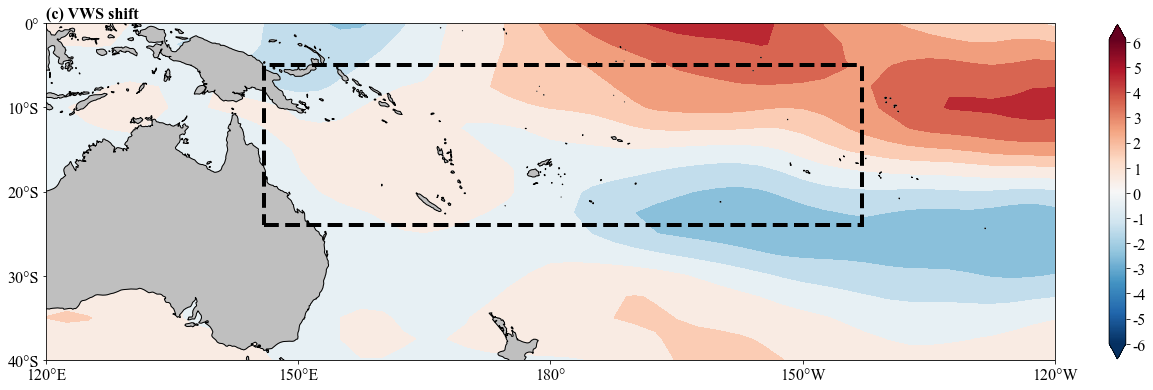

In [50]:
from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from matplotlib import rcParams
from matplotlib import patches

# 设置字体
config = {
    "font.family": 'Times New Roman',
    "font.size": 16,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 6.1
MIN = -6
INTER = 1
# 设置经纬度
lon = np.append(vlon[:].data, [360.0])
# lon = vlon[:].data
lat = vlat[:].data
diff_2d = diff[0]
# print(diff_2d)
new_diff=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff.append(tmp.tolist())
new_diff = np.array(new_diff)
fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
# leftlon, rightlon, lowerlat, upperlat = (-180, 180.1, -45, 46)
leftlon, rightlon, lowerlat, upperlat = (120,240, -40, 0)

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1], projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
# fig_ax1.set_xticks(np.arange(-60,60.1,30), crs=ccrs.PlateCarree())
fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())

fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(c) VWS shift',loc='left',fontsize =16, fontweight='bold')

cont = fig_ax1.contourf(lon, lat, new_diff, 
                 levels=np.arange(MIN,MAX,INTER), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

black_quarter = patches.Rectangle((146,-24),71,19,linestyle = 'dashed', 
                                  lw=4, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
fig_ax1.add_patch(black_quarter)

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

# cmap=plt.cm.RdBu_r  #引用NCL的colormap
# # cmap=cmaps.BlueWhiteOrangeRed  

# newcolors=cmap(np.linspace(0,1,12))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::1])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
#                                        cmap = newcmap
                                      ),
#                  format='%.2g',
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',
                 ticks=np.arange(MIN,MAX,INTER).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.0155) 

plt.savefig("wnd.png",dpi=300,bbox_inches='tight')
plt.show()